In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Target cities filter for DISPLAY ONLY (fitting uses all cities)
# Format: (City, State) tuples to avoid duplicates like "Austin, TX" vs "Austin, IN"
# Set to None to display all cities
DISPLAY_CITIES = [
    # California
    ('Los Angeles', 'CA'), ('San Francisco', 'CA'), ('San Diego', 'CA'), 
    ('San Jose', 'CA'), ('Sacramento', 'CA'),
    # Texas
    ('Austin', 'TX'), ('Houston', 'TX'), ('Dallas', 'TX'), 
    ('San Antonio', 'TX'), ('Fort Worth', 'TX'),
    # Florida
    ('Miami', 'FL'), ('Tampa', 'FL'), ('Orlando', 'FL'), ('Jacksonville', 'FL'),
    # New York
    ('New York', 'NY'), ('Buffalo', 'NY'),
    # Other Major Cities
    ('Chicago', 'IL'), ('Phoenix', 'AZ'), ('Philadelphia', 'PA'), 
    ('Seattle', 'WA'), ('Denver', 'CO'), ('Boston', 'MA'),
    ('Atlanta', 'GA'), ('Las Vegas', 'NV'), ('Portland', 'OR'), 
    ('Charlotte', 'NC'), ('Nashville', 'TN'),
    ('Minneapolis', 'MN'), ('Detroit', 'MI'), ('Baltimore', 'MD'), 
    ('Salt Lake City', 'UT'), ('Raleigh', 'NC'),
    ('Kansas City', 'MO'), ('Columbus', 'OH'), ('Indianapolis', 'IN'), 
    ('Cleveland', 'OH'), ('Cincinnati', 'OH'),
    ('Pittsburgh', 'PA'), ('Milwaukee', 'WI'), ('New Orleans', 'LA'), 
    ('Oklahoma City', 'OK'), ('Louisville', 'KY'),
    ('Memphis', 'TN'), ('Richmond', 'VA'), ('Hartford', 'CT'), 
    ('Providence', 'RI'), ('Birmingham', 'AL'),
    ('Tucson', 'AZ'), ('Albuquerque', 'NM'), ('Omaha', 'NE'), 
    ('Honolulu', 'HI'), ('Boise', 'ID'),
]

print("Financial Engineering: City Rent Betas")
print(f"Display filter: {len(DISPLAY_CITIES) if DISPLAY_CITIES else 'All'} cities")
print("Note: Betas are calculated using ALL cities for proper state market estimation")

Financial Engineering: City Rent Betas
Target cities: 52


## Load Data

In [ ]:
# Load rent data (use ALL cities for fitting)
rents = pd.read_csv('regression_data/median_rent_by_place.csv')
rents = rents.rename(columns={'RegionName': 'City', 'StateName': 'State'})

# Identify year columns
year_cols = [c for c in rents.columns if c.isdigit() and int(c) >= 2009]
years = sorted([int(c) for c in year_cols])

print(f"Full dataset: {rents.shape[0]} cities (ALL used for fitting)")
print(f"Years: {years}")
print(f"States: {rents['State'].nunique()}")
rents.head()

Full dataset: 10279 cities
Filtered to target cities: 47 cities
Years: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
States: 30


,City,State,2009,2010,2011,2012,2013,2014,2015,2016,...,2014_yoy,2015_yoy,2016_yoy,2017_yoy,2018_yoy,2019_yoy,2020_yoy,2021_yoy,2022_yoy,2023_yoy
100,Albuquerque,NM,686.0,712.0,738.0,758.0,789.0,798.0,799.0,816.0,...,0.011407,0.001253,0.021277,0.020833,0.026411,0.021053,0.018328,0.048369,0.087983,0.070020
391,Atlanta,GA,881.0,884.0,910.0,931.0,948.0,969.0,975.0,998.0,...,0.022152,0.006192,0.023590,0.039078,0.059788,0.049136,0.064180,0.093725,0.126677,0.069444
455,Austin,TX,860.0,882.0,920.0,950.0,978.0,1012.0,1047.0,1106.0,...,0.034765,0.034585,0.056351,0.053345,0.051502,0.044898,0.051562,0.051263,0.094700,0.068431
513,Baltimore,MD,813.0,859.0,889.0,909.0,924.0,944.0,951.0,974.0,...,0.021645,0.007415,0.024185,0.035934,0.041625,0.020932,0.019571,0.047532,0.077661,0.044534
832,Birmingham,AL,672.0,683.0,706.0,717.0,728.0,728.0,728.0,744.0,...,0.000000,0.000000,0.021978,0.034946,0.035065,0.050188,0.039427,0.041379,0.098234,0.052261


## Calculate Rent Growth Rates (Returns)

In [46]:
# Calculate YoY growth rates for each city
growth_cols = []
for i in range(1, len(years)):
    prev_year = str(years[i-1])
    curr_year = str(years[i])
    growth_col = f'growth_{curr_year}'
    
    rents[growth_col] = (rents[curr_year] - rents[prev_year]) / rents[prev_year] * 100
    growth_cols.append(growth_col)

print(f"Growth columns: {growth_cols}")

# Preview
rents[['City', 'State'] + growth_cols[:5]].head()

Growth columns: ['growth_2010', 'growth_2011', 'growth_2012', 'growth_2013', 'growth_2014', 'growth_2015', 'growth_2016', 'growth_2017', 'growth_2018', 'growth_2019', 'growth_2020', 'growth_2021', 'growth_2022', 'growth_2023']


,City,State,growth_2010,growth_2011,growth_2012,growth_2013,growth_2014
100,Albuquerque,NM,3.790087,3.651685,2.710027,4.089710,1.140684
391,Atlanta,GA,0.340522,2.941176,2.307692,1.825994,2.215190
455,Austin,TX,2.558140,4.308390,3.260870,2.947368,3.476483
513,Baltimore,MD,5.658057,3.492433,2.249719,1.650165,2.164502
832,Birmingham,AL,1.636905,3.367496,1.558074,1.534170,0.000000


## Calculate State-Level Market Returns

In [47]:
# Aggregate to state level (market index)
# Using mean of city growth rates within each state
state_returns = rents.groupby('State')[growth_cols].mean()

print(f"State returns shape: {state_returns.shape}")
state_returns.head()

State returns shape: (30, 14)


,growth_2010,growth_2011,growth_2012,growth_2013,growth_2014,growth_2015,growth_2016,growth_2017,growth_2018,growth_2019,growth_2020,growth_2021,growth_2022,growth_2023
State,,,,,,,,,,,,,,
AL,1.636905,3.367496,1.558074,1.534170,0.000000,0.000000,2.197802,3.494624,3.506494,5.018821,3.942652,4.137931,9.823400,5.226131
AZ,2.506742,2.506545,1.479871,1.044523,0.883911,0.856621,2.755034,4.066422,3.856618,3.975430,3.118244,6.080403,10.885970,9.583681
CA,2.877299,3.546125,2.535873,1.879928,2.292591,1.866166,4.202750,5.645298,6.488857,5.931441,5.321389,6.840140,9.199718,5.249070
CO,2.439024,4.260652,3.725962,2.317497,3.397508,5.366922,7.588358,9.275362,7.603890,7.723911,6.559878,7.015032,11.371237,6.306306
CT,3.870968,3.975155,2.150538,2.690058,1.025057,0.338219,2.696629,2.297593,2.566845,2.711157,1.928934,5.278884,9.176916,5.805893


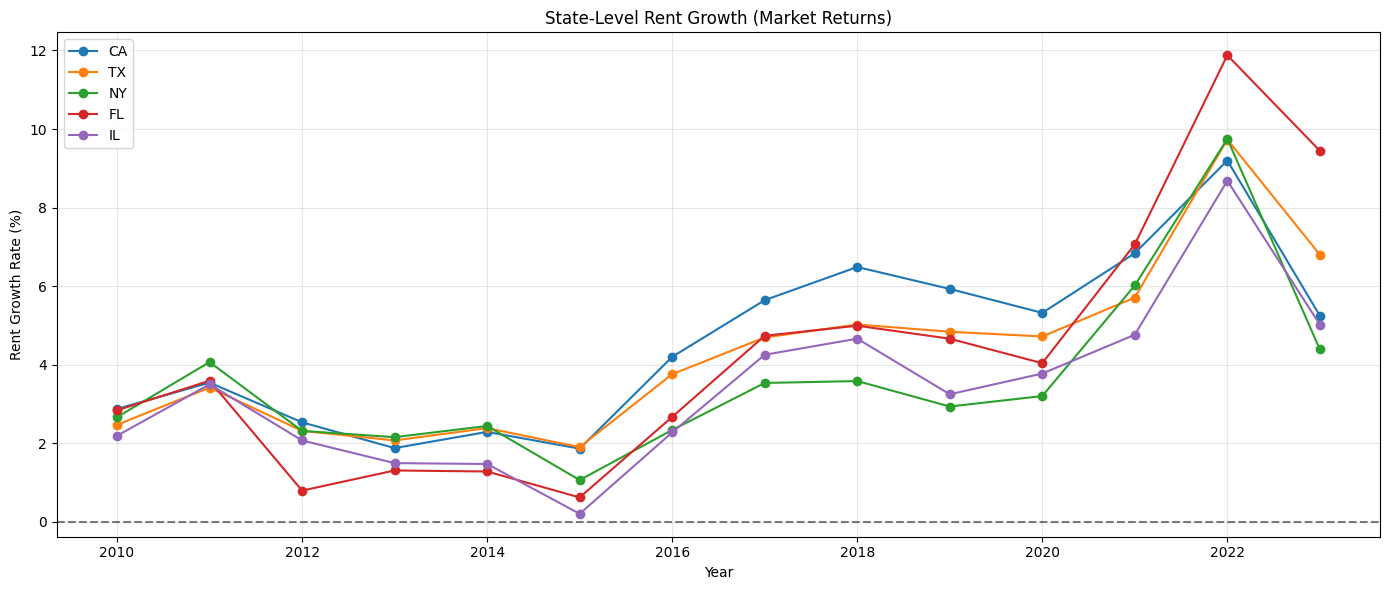

In [48]:
# Visualize state market returns over time
fig, ax = plt.subplots(figsize=(14, 6))

# Plot a few example states
example_states = ['CA', 'TX', 'NY', 'FL', 'IL']
growth_years = [int(c.replace('growth_', '')) for c in growth_cols]

for state in example_states:
    if state in state_returns.index:
        ax.plot(growth_years, state_returns.loc[state].values, marker='o', label=state)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Rent Growth Rate (%)')
ax.set_title('State-Level Rent Growth (Market Returns)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Calculate City Betas

In [49]:
def calculate_beta(city_returns, market_returns):
    """
    Calculate beta: Cov(city, market) / Var(market)
    
    Args:
        city_returns: array of city rent growth rates
        market_returns: array of state (market) rent growth rates
    
    Returns:
        beta, r_squared
    """
    # Remove NaN values
    mask = ~(np.isnan(city_returns) | np.isnan(market_returns))
    city_r = city_returns[mask]
    market_r = market_returns[mask]
    
    if len(city_r) < 3:  # Need at least 3 observations
        return np.nan, np.nan
    
    # Calculate beta
    covariance = np.cov(city_r, market_r)[0, 1]
    market_variance = np.var(market_r, ddof=1)
    
    if market_variance == 0:
        return np.nan, np.nan
    
    beta = covariance / market_variance
    
    # Calculate R² from regression
    alpha = np.mean(city_r) - beta * np.mean(market_r)
    predicted = alpha + beta * market_r
    ss_res = np.sum((city_r - predicted) ** 2)
    ss_tot = np.sum((city_r - np.mean(city_r)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return beta, r_squared

# Calculate market size (number of cities per state)
market_size = rents.groupby('State').size().to_dict()
print("Beta calculation function defined.")
print(f"Market sizes: {dict(list(market_size.items())[:5])}...")

Beta calculation function defined.
Market sizes: {'AL': 1, 'AZ': 2, 'CA': 5, 'CO': 1, 'CT': 1}...


In [ ]:
# Calculate beta for each city relative to its state
beta_results = []

for idx, row in rents.iterrows():
    city = row['City']
    state = row['State']
    
    # Get city returns
    city_returns = row[growth_cols].values.astype(float)
    
    # Get state (market) returns
    if state in state_returns.index:
        market_returns = state_returns.loc[state].values.astype(float)
    else:
        continue
    
    beta, r_squared = calculate_beta(city_returns, market_returns)
    
    # Also calculate volatility metrics
    city_vol = np.nanstd(city_returns)
    market_vol = np.nanstd(market_returns)
    
    beta_results.append({
        'City': city,
        'State': state,
        'Beta': beta,
        'R_Squared': r_squared,
        'Market_Size': market_size.get(state, 0),  # Number of cities in state
        'City_Volatility': city_vol,
        'State_Volatility': market_vol,
        'Avg_Growth': np.nanmean(city_returns),
    })

beta_df = pd.DataFrame(beta_results)
beta_df = beta_df.dropna(subset=['Beta'])

print(f"Calculated betas for {len(beta_df)} cities (all cities)")

# Create display-filtered dataframe for outputs
if DISPLAY_CITIES:
    display_set = set(DISPLAY_CITIES)
    beta_display = beta_df[beta_df.apply(lambda row: (row['City'], row['State']) in display_set, axis=1)].copy()
    # Check for missing display cities
    found_pairs = set(zip(beta_display['City'], beta_display['State']))
    missing = display_set - found_pairs
    if missing:
        print(f"Warning: {len(missing)} display cities not found: {missing}")
    print(f"Displaying {len(beta_display)} target cities")
else:
    beta_display = beta_df.copy()
    print("Displaying all cities")

beta_display.head(10)

Calculated betas for 47 cities


,City,State,Beta,R_Squared,Market_Size,City_Volatility,State_Volatility,Avg_Growth
0,Albuquerque,NM,1.000000,1.000000,1,2.223336,2.223336,3.352481
1,Atlanta,GA,1.000000,1.000000,1,3.373895,3.373895,4.486536
2,Austin,TX,0.785640,0.904251,5,1.732844,2.097397,4.801078
3,Baltimore,MD,1.000000,1.000000,1,1.801744,1.801744,3.368145
4,Birmingham,AL,1.000000,1.000000,1,2.424454,2.424454,3.246036
5,Boston,MA,1.000000,1.000000,1,2.531079,2.531079,4.329460
6,Buffalo,NY,1.250520,0.968482,2,2.610262,2.054184,3.212730
7,Charlotte,NC,1.019443,0.988304,2,2.555119,2.491687,4.568708
8,Chicago,IL,1.000000,1.000000,1,2.016331,2.016331,3.403686
9,Cincinnati,OH,1.026922,0.975670,3,2.537919,2.441135,3.666950


## Beta Distribution Analysis

In [ ]:
# Summary statistics (for display cities)
print(f"Beta Distribution Summary ({len(beta_display)} display cities):")
print(f"  Mean:   {beta_display['Beta'].mean():.3f}")
print(f"  Median: {beta_display['Beta'].median():.3f}")
print(f"  Std:    {beta_display['Beta'].std():.3f}")
print(f"  Min:    {beta_display['Beta'].min():.3f}")
print(f"  Max:    {beta_display['Beta'].max():.3f}")

# Categorize betas
print(f"\nBeta Categories:")
print(f"  High Beta (> 1.2):  {(beta_display['Beta'] > 1.2).sum()} cities ({(beta_display['Beta'] > 1.2).mean()*100:.1f}%)")
print(f"  Normal (0.8-1.2):   {((beta_display['Beta'] >= 0.8) & (beta_display['Beta'] <= 1.2)).sum()} cities")
print(f"  Low Beta (< 0.8):   {(beta_display['Beta'] < 0.8).sum()} cities ({(beta_display['Beta'] < 0.8).mean()*100:.1f}%)")
print(f"  Negative Beta:      {(beta_display['Beta'] < 0).sum()} cities"))

Beta Distribution Summary:
  Mean:   1.000
  Median: 1.000
  Std:    0.131
  Min:    0.686
  Max:    1.422

Beta Categories:
  High Beta (> 1.2):  3 cities (6.4%)
  Normal (0.8-1.2):   40 cities
  Low Beta (< 0.8):   4 cities (8.5%)
  Negative Beta:      0 cities


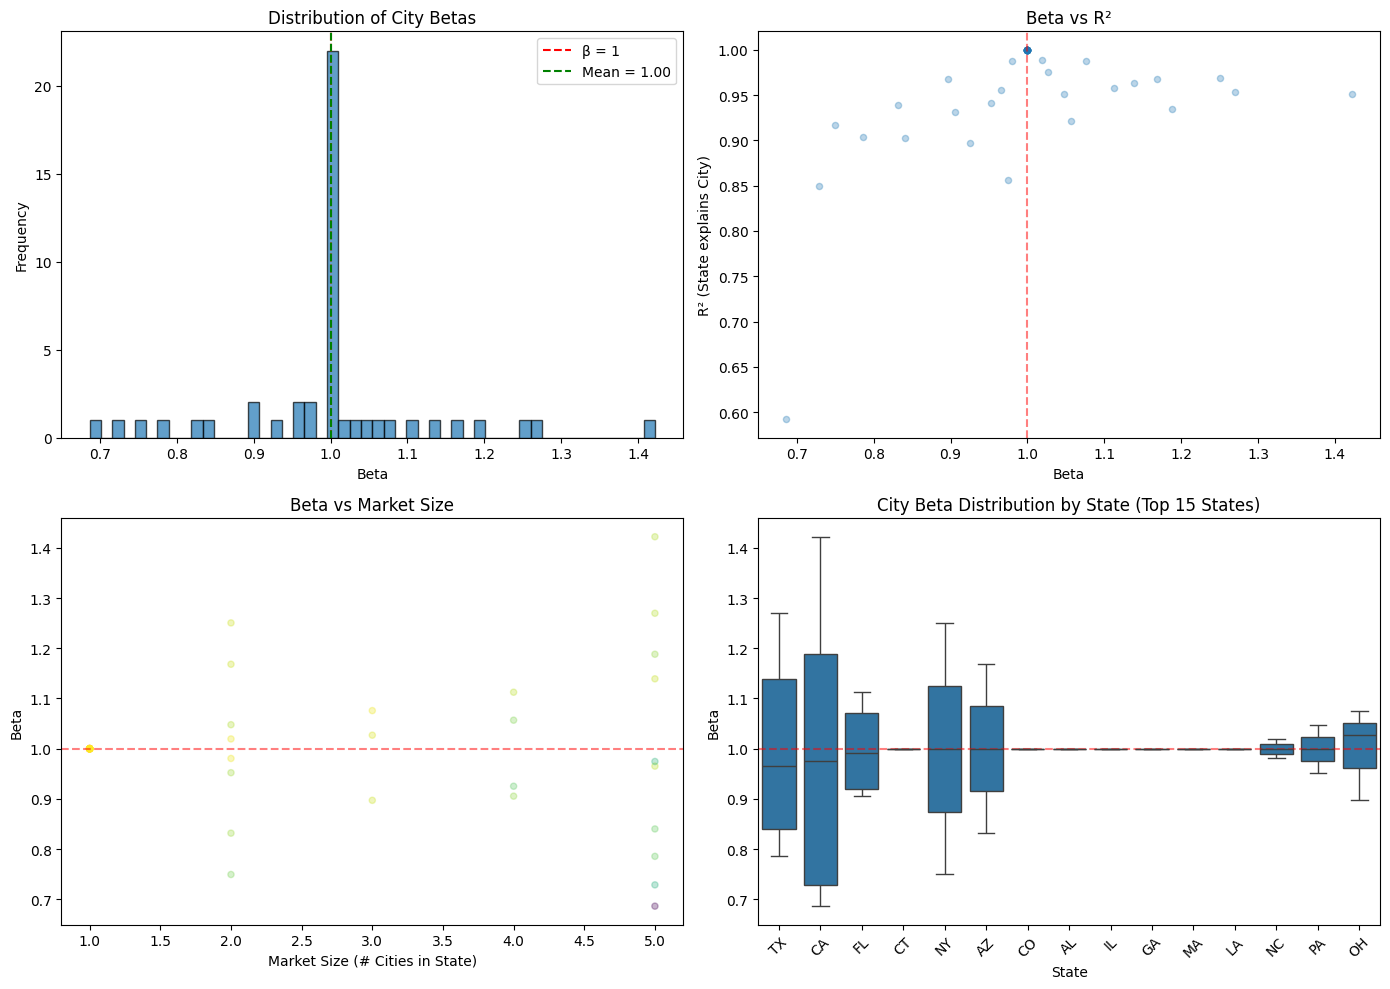

In [ ]:
# Visualize beta distribution (display cities)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Beta histogram
axes[0, 0].hist(beta_display['Beta'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=1.0, color='red', linestyle='--', label='β = 1')
axes[0, 0].axvline(x=beta_display['Beta'].mean(), color='green', linestyle='--', label=f'Mean = {beta_display["Beta"].mean():.2f}')
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of City Betas')
axes[0, 0].legend()

# Beta vs R² (how well does state explain city?)
axes[0, 1].scatter(beta_display['Beta'], beta_display['R_Squared'], alpha=0.5, s=30)
axes[0, 1].axvline(x=1.0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Beta')
axes[0, 1].set_ylabel('R² (State explains City)')
axes[0, 1].set_title('Beta vs R²')

# Beta vs Market Size
axes[1, 0].scatter(beta_display['Market_Size'], beta_display['Beta'], alpha=0.5, s=30, c=beta_display['R_Squared'], cmap='viridis')
axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Market Size (# Cities in State)')
axes[1, 0].set_ylabel('Beta')
axes[1, 0].set_title('Beta vs Market Size')

# Beta by state (boxplot)
states_in_display = beta_display['State'].unique()
beta_display_states = beta_display.copy()
state_order = beta_display_states.groupby('State')['Beta'].median().sort_values().index
sns.boxplot(data=beta_display_states, x='State', y='Beta', order=state_order, ax=axes[1, 1])
axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('State')
axes[1, 1].set_ylabel('Beta')
axes[1, 1].set_title('City Beta Distribution by State')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Highest and Lowest Beta Cities

In [ ]:
# Top highest beta cities (most volatile/sensitive to state market)
print("HIGHEST BETA CITIES (Most Sensitive to State Market):")
print("="*70)
high_beta = beta_display.nlargest(20, 'Beta')[['City', 'State', 'Beta', 'R_Squared', 'Market_Size', 'Avg_Growth']]
print(high_beta.to_string(index=False))

TOP 20 HIGHEST BETA CITIES (Most Sensitive to State Market):
         City State     Beta  R_Squared  Market_Size  Avg_Growth
   Sacramento    CA 1.422059   0.950848            5    4.278414
       Dallas    TX 1.269731   0.953898            5    4.384925
      Buffalo    NY 1.250520   0.968482            2    3.212730
    San Diego    CA 1.188102   0.934319            5    4.374198
      Phoenix    AZ 1.168191   0.968040            2    4.218955
   Fort Worth    TX 1.139158   0.963890            5    4.367672
        Tampa    FL 1.112478   0.958101            4    4.500563
    Cleveland    OH 1.075870   0.987280            3    2.658366
      Orlando    FL 1.056772   0.921158            4    4.048813
   Pittsburgh    PA 1.047785   0.950906            2    4.214947
   Cincinnati    OH 1.026922   0.975670            3    3.666950
    Charlotte    NC 1.019443   0.988304            2    4.568708
  Albuquerque    NM 1.000000   1.000000            1    3.352481
      Memphis    TN 1.000000 

In [ ]:
# Top lowest beta cities (most stable/defensive)
print("LOWEST BETA CITIES (Most Stable/Defensive):")
print("="*70)
low_beta = beta_display.nsmallest(20, 'Beta')[['City', 'State', 'Beta', 'R_Squared', 'Market_Size', 'Avg_Growth']]
print(low_beta.to_string(index=False))

TOP 20 LOWEST BETA CITIES (Most Stable/Defensive):
         City State     Beta  R_Squared  Market_Size  Avg_Growth
     San Jose    CA 0.686447   0.592227            5    5.118311
San Francisco    CA 0.728843   0.849824            5    4.623763
     New York    NY 0.749480   0.916928            2    4.000165
       Austin    TX 0.785640   0.904251            5    4.801078
       Tucson    AZ 0.831809   0.938864            2    3.438190
  San Antonio    TX 0.840210   0.902224            5    3.980204
     Columbus    OH 0.897208   0.967554            3    3.693368
 Jacksonville    FL 0.905490   0.931732            4    3.545793
        Miami    FL 0.925260   0.896884            4    5.035607
 Philadelphia    PA 0.952215   0.941166            2    3.667547
      Houston    TX 0.965261   0.955624            5    3.848483
  Los Angeles    CA 0.974548   0.856739            5    4.418400
      Raleigh    NC 0.980557   0.987370            2    4.339736
     Hartford    CT 1.000000   1.000000

In [ ]:
# Top cities by average growth
print("HIGHEST AVERAGE GROWTH CITIES:")
print("="*70)
high_growth = beta_display.nlargest(20, 'Avg_Growth')[['City', 'State', 'Beta', 'R_Squared', 'Market_Size', 'Avg_Growth']]
print(high_growth.to_string(index=False))

TOP 20 HIGHEST AVERAGE GROWTH CITIES:
          City State     Beta  R_Squared  Market_Size  Avg_Growth
        Denver    CO 1.000000   1.000000            1    6.067967
       Seattle    WA 1.000000   1.000000            1    5.688862
      Portland    OR 1.000000   1.000000            1    5.186584
      San Jose    CA 0.686447   0.592227            5    5.118311
         Miami    FL 0.925260   0.896884            4    5.035607
Salt Lake City    UT 1.000000   1.000000            1    4.878629
        Austin    TX 0.785640   0.904251            5    4.801078
 San Francisco    CA 0.728843   0.849824            5    4.623763
     Charlotte    NC 1.019443   0.988304            2    4.568708
         Tampa    FL 1.112478   0.958101            4    4.500563
       Atlanta    GA 1.000000   1.000000            1    4.486536
   Los Angeles    CA 0.974548   0.856739            5    4.418400
        Dallas    TX 1.269731   0.953898            5    4.384925
     San Diego    CA 1.188102   0.9343

## State-Level Beta Summary

In [ ]:
# Average beta by state (for display cities only)
state_beta_summary = beta_display.groupby('State').agg({
    'Beta': ['mean', 'std', 'min', 'max', 'count'],
    'Market_Size': 'first',
    'R_Squared': 'mean',
}).round(3)

state_beta_summary.columns = ['Beta_Mean', 'Beta_Std', 'Beta_Min', 'Beta_Max', 'Display_Cities', 'Market_Size', 'R2_Mean']
state_beta_summary = state_beta_summary.sort_values('Beta_Mean', ascending=False)

print("STATE BETA SUMMARY (for display cities, sorted by mean beta):")
print(state_beta_summary.to_string())

STATE BETA SUMMARY (sorted by within-state beta dispersion):
       Beta_Mean  Beta_Std  Beta_Min  Beta_Max  Market_Size  R2_Mean
State                                                               
NY           1.0     0.354     0.749     1.251            2    0.943
CA           1.0     0.311     0.686     1.422            5    0.837
AZ           1.0     0.238     0.832     1.168            2    0.953
TX           1.0     0.203     0.786     1.270            5    0.936
FL           1.0     0.101     0.905     1.112            4    0.927
OH           1.0     0.092     0.897     1.076            3    0.977
PA           1.0     0.068     0.952     1.048            2    0.946
NC           1.0     0.027     0.981     1.019            2    0.988
AL           1.0       NaN     1.000     1.000            1    1.000
CO           1.0       NaN     1.000     1.000            1    1.000
CT           1.0       NaN     1.000     1.000            1    1.000
GA           1.0       NaN     1.000     1

In [57]:
# Save beta results
beta_df.to_csv('regression_data/city_betas.csv', index=False)
print(f"Saved city betas to regression_data/city_betas.csv")
print(f"Shape: {beta_df.shape}")

Saved city betas to regression_data/city_betas.csv
Shape: (47, 8)


## Key Insights

In [ ]:
print("\n" + "="*70)
print(f"KEY INSIGHTS ({len(beta_display)} display cities)")
print("="*70)

print(f"\n1. BETA DISTRIBUTION:")
print(f"   - Average city beta: {beta_display['Beta'].mean():.3f}")
print(f"   - Most cities cluster around β ≈ 1 (move with state)")

print(f"\n2. HIGH BETA CITIES (β > 1.2):")
print(f"   - {(beta_display['Beta'] > 1.2).sum()} cities amplify state trends")
print(f"   - Higher risk, higher potential returns")
if len(high_beta) > 0:
    print(f"   - Example: {high_beta.iloc[0]['City']}, {high_beta.iloc[0]['State']} (β = {high_beta.iloc[0]['Beta']:.2f})")

print(f"\n3. LOW BETA CITIES (β < 0.8):")
print(f"   - {(beta_display['Beta'] < 0.8).sum()} cities are defensive/stable")
print(f"   - Less volatile, more predictable")
if len(low_beta) > 0:
    print(f"   - Example: {low_beta.iloc[0]['City']}, {low_beta.iloc[0]['State']} (β = {low_beta.iloc[0]['Beta']:.2f})")

print(f"\n4. MARKET SIZE:")
print(f"   - Larger markets (more cities) may have more stable betas")
print(f"   - Avg market size: {beta_display['Market_Size'].mean():.1f} cities per state")

print(f"\n5. R² (STATE EXPLAINS CITY):")
print(f"   - Average R²: {beta_display['R_Squared'].mean():.3f}")

print(f"   - Low R² = city moves independently of state")print(f"   - High R² = city closely follows state trends"))


KEY INSIGHTS

1. BETA DISTRIBUTION:
   - Average city beta: 1.000
   - Most cities cluster around β ≈ 1 (move with state)

2. HIGH BETA CITIES (β > 1.2):
   - 3 cities amplify state trends
   - Higher risk, higher potential returns
   - Example: Sacramento, CA (β = 1.42)

3. LOW BETA CITIES (β < 0.8):
   - 4 cities are defensive/stable
   - Less volatile, more predictable
   - Example: San Jose, CA (β = 0.69)

4. MARKET SIZE:
   - Larger markets (more cities) may have more stable betas
   - Avg market size: 2.4 cities per state

5. R² (STATE EXPLAINS CITY):
   - Average R²: 0.961
   - Low R² = city moves independently of state
   - High R² = city closely follows state trends
